In [ ]:
# Note: I ran this code in google colab.
# Step1: load dataset (Use !pip install datasets)
from datasets import load_dataset


# NSMC (Korean) — load the pre-converted Parquet revision
nsmc = load_dataset("e9t/nsmc", revision="refs/convert/parquet")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# to check the features of data:
print(nsmc, "\n")


print(nsmc["train"][0], "\n")


print(nsmc["train"].features, "\n")


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
}) 

{'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0} 

{'id': Value('string'), 'document': Value('string'), 'label': ClassLabel(names=['negative', 'positive'])} 



In [ ]:
# We should create the validation data and in dictionary format since the .map() function requires it.
from datasets import DatasetDict
split = nsmc["train"].train_test_split(test_size=0.1, seed=42)
nsmc = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
    "test": nsmc["test"],
})

In [ ]:
nsmc

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 135000
    })
    validation: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 15000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [ ]:
# Step2: load a pre-trained tokenizer
from transformers import AutoTokenizer
checkpoint = "klue/roberta-base"
Tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
print(Tokenizer(nsmc['train'][0]['document']))

{'input_ids': [0, 19875, 2073, 5861, 2145, 3738, 2079, 5103, 2470, 10628, 1485, 2170, 10092, 2062, 18, 3673, 831, 13439, 16773, 2154, 2079, 11878, 2044, 65, 65, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
def tokenize_fn(batch):
    return Tokenizer(batch["document"], truncation=True)    # Set truncation to True to ensure sequences longer than the model's maximum length are cut down to fit.


tok_dataset=nsmc.map(tokenize_fn, batched=True,remove_columns=["document", "id"], )

Map:   0%|          | 0/135000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Step3: Now we go for LORA. You can see: https://huggingface.co/docs/peft/en/task_guides/lora_based_methods
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification
checkpoint = "klue/roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)

#for name, _ in model.named_modules(): # To check for target_modules in Config target_modules=["query", "value"] for different model the name of "query" and "value" are different.
#    print(name)

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,181,954 || all params: 111,801,604 || trainable%: 1.0572


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred): #eval_pred is a tuple (logits, labels) that the Trainer gives you after running evaluation.
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
# Step 4: Before starting training, set up MLflow so we can log metrics and save the model during training.
!pip install mlflow
import mlflow
#mlflow.end_run()
#mlflow.set_experiment("model-LORAv4") #with which name your colloborate should know it
#print(mlflow.get_tracking_uri())
#mlflow.set_tracking_uri("file:///content/mlruns4")  #for local tracking server with UI: "http://127.0.0.0:5000/". if this is in a server that yuor colloborator use you can find this by print the prevoius cell.

In [ ]:
import os, mlflow
mlflow.end_run()  # close any stray run

mlflow.set_tracking_uri("file:///content/mlruns4")
mlflow.set_experiment("model-LORAv4")

print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment:", mlflow.get_experiment_by_name("model-LORAv4").experiment_id)


In [ ]:
from transformers import TrainingArguments, Trainer
from datetime import datetime

batch_size = 16
peft_model_id = f"./lora-sst2-run1-{datetime.now().strftime('%Y%m%d-%H%M%S')}"   #output directory where checkpoints and logs will be saved.
args = TrainingArguments(
    peft_model_id,
    remove_unused_columns=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    label_names=["label"],
    report_to=["mlflow"]

)


trainer = Trainer(
    model,
    args,
    train_dataset=tok_dataset['train'],
    eval_dataset=tok_dataset['validation'],
    processing_class=Tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.281800,No log
2,0.266100,No log
3,0.235900,No log
4,0.220900,No log
5,0.198300,No log


TrainOutput(global_step=42190, training_loss=0.2463888278191732, metrics={'train_runtime': 5338.4021, 'train_samples_per_second': 126.442, 'train_steps_per_second': 7.903, 'total_flos': 2.219628684819533e+16, 'train_loss': 0.2463888278191732, 'epoch': 5.0})

In [ ]:
# Eval metrics on validation set
eval_metrics = trainer.evaluate()
print("Eval metrics:", eval_metrics)



Eval metrics: {'eval_runtime': 59.133, 'eval_samples_per_second': 253.665, 'eval_steps_per_second': 15.863, 'epoch': 5.0}


In [ ]:
no_label_val = tok_dataset["validation"].remove_columns("label")
pred = trainer.predict(no_label_val)

In [ ]:
pred

PredictionOutput(predictions=array([[-0.6480095 ,  0.27015758],
       [-3.1751459 ,  2.4863315 ],
       [-2.6377656 ,  2.242806  ],
       ...,
       [-1.7124611 ,  1.4084432 ],
       [ 2.2275481 , -1.5385627 ],
       [ 3.0416362 , -2.6694336 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 51.7536, 'test_samples_per_second': 289.835, 'test_steps_per_second': 18.124})

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Predicted classes
y_pred = np.argmax(pred.predictions, axis=-1)

# 2. True labels from original dataset
# Make sure to use the same validation split you predicted on
y_true = np.array(tok_dataset["validation"]["label"])

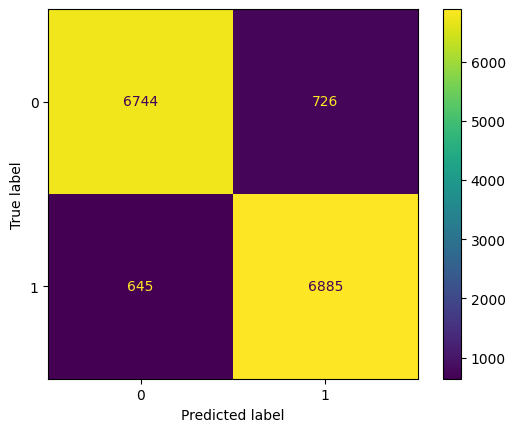

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d")